In [1]:
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end
from temgymbasic.jax_ray import Ray
from temgymbasic.jax_source import ParallelBeam, PointBeam
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from temgymbasic.jax_utils import calculate_phi_0

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm.auto as tqdm

%matplotlib widget

In [2]:
import sympy as sp

def calculate_object_plane(f, z2):
	return (1/f - 1/z2)**-1


def calculate_image_plane(f, z1):
	return (1/f + 1/z1)**-1


def calculate_focal_length(z1, z2):
	return (1/z1 + 1/z2)**-1

def propagation_matrix(d, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, d], [0, 1]])
	else:
		return xp.array([[1, d], [0, 1]])


def thin_lens_matrix(f, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, 0], [-1/f, 1]])
	else:
		return xp.array([[1, 0], [-1/f, 1]])

def imaging_matrix(M, f, xp=sp):
	if xp == sp:
		return xp.Matrix([[M, 0], [-1/f, 1/M]])
	else:
		return xp.array([[M, 0], [-1/f, 1/M]])
	
def diffraction_matrix(L, f, xp=sp):
	
	obj_prop_mat = propagation_matrix(L, xp)
	lens_mat = thin_lens_matrix(f, xp)
	f_prop_mat = propagation_matrix(f, xp)

	return f_prop_mat @ lens_mat @ obj_prop_mat


(817, 1398, 4)
0.0010204081632653062


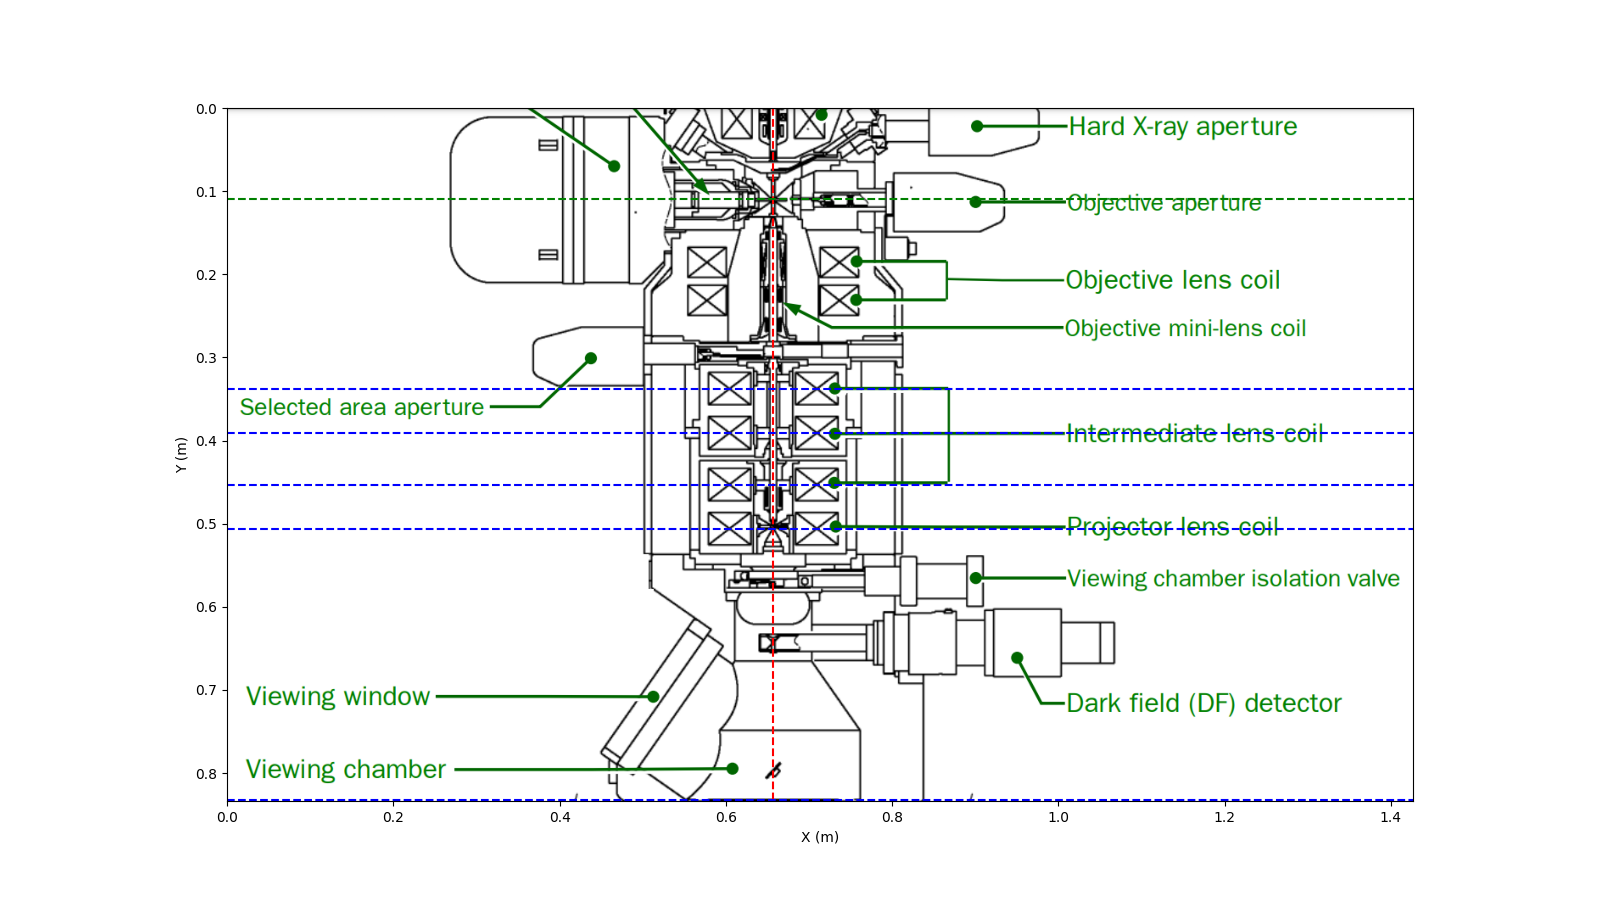

0.19030612244897963


In [3]:
Length_of_Chamber = 0.20 #m
Pixels_of_Chamber = 196 #pixels
scale = Pixel_Size = Length_of_Chamber/Pixels_of_Chamber #m

optical_axis_px = 644 #px
optical_axis_m = optical_axis_px * scale

sample_y_px = 107.5 #px
sample_x_px = optical_axis_px #px

sample_y_m = sample_y_px * scale
sample_x_m = sample_x_px * scale

z_sa_aperture_px = 294.0
z_il1_px = 331.0
z_il2_px = z_il1_px + 52
z_il3_px = z_il2_px + 61
z_pl1_px = z_il3_px + 52
z_det = z_pl1_px + 320

z_sa_aperture_m = z_sa_aperture_px * scale - sample_y_m
z_il1_m = z_il1_px * scale - sample_y_m
z_il2_m = z_il2_px * scale - sample_y_m
z_il3_m = z_il3_px * scale - sample_y_m
z_pl1_m = z_pl1_px * scale - sample_y_m
z_det_m = z_det * scale - sample_y_m

# Load the image
img = mpimg.imread("neoarm.png")
print(img.shape)

# Define scale
print(scale)
height, width = img.shape[:2]
extent = [0, width*scale, height*scale, 0]

# Plot the image
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(img, extent=extent, origin='upper')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.vlines(optical_axis_m, 0, height*scale, color='r', linestyle='--', label='Optical Axis')
ax.hlines(sample_y_m, 0, width*scale, color='g', linestyle='--', label='Sample Y')
ax.hlines(z_il1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl1')
ax.hlines(z_il2_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl2')
ax.hlines(z_il3_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl3')
ax.hlines(z_pl1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl4')
ax.hlines(z_det_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='detector')
plt.show()

print(z_sa_aperture_m)

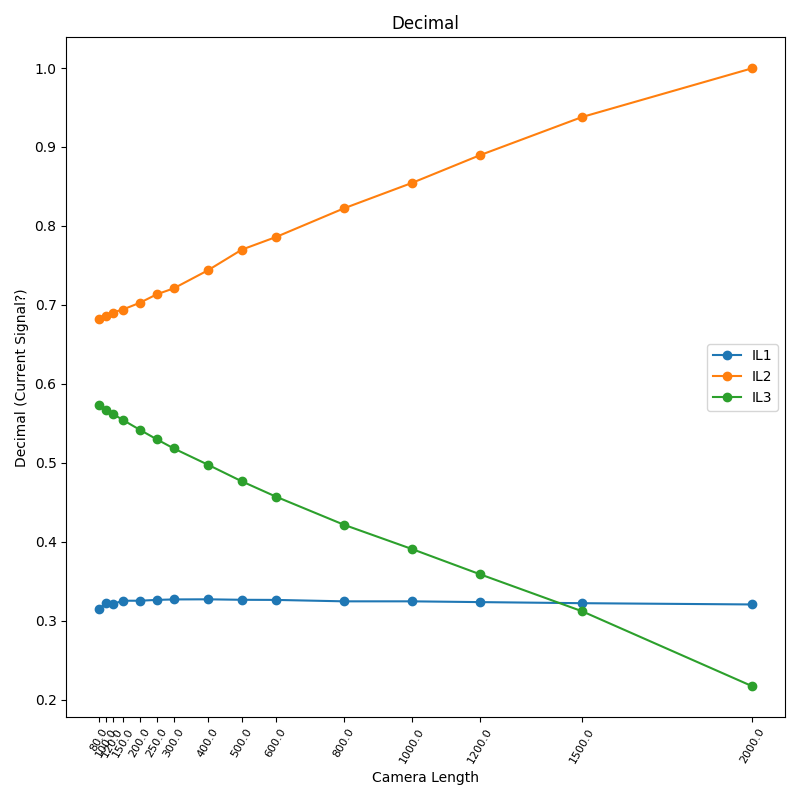

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np


with open(r'results_diff.json') as f:
    data = json.load(f)

lenses = (
 "IL1", 
 "IL2", 
 "IL3",
)

results = {}

for key in data.keys():
    for lens in data[key].keys():
        current = data[key][lens]
        if lens not in results:
            results[lens] = []
        
        camera_length_float = float(key)
        decimal = int(current, 16) / 65535.0
        results[lens].append((camera_length_float, decimal))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_title('Decimal')
ax.set_xlabel('Camera Length')
ax.set_ylabel('Decimal (Current Signal?)')

cameralengths_sorted = sorted([float(k) for k in data.keys()])
ax.set_xticks(cameralengths_sorted)
ax.set_xticklabels(cameralengths_sorted)
ax.tick_params(axis='x', rotation=60, labelsize=8)

for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    ax.plot(cameralength, decimal, label=lens, marker='o', linestyle='-')

ax.legend(loc='center right')
plt.tight_layout()
plt.show()


$$
\frac{1}{f} \propto {\text{I}^2} \\

\text{decimal} \propto I \\

f \propto \frac{1}{\text{decimal}^2}
$$


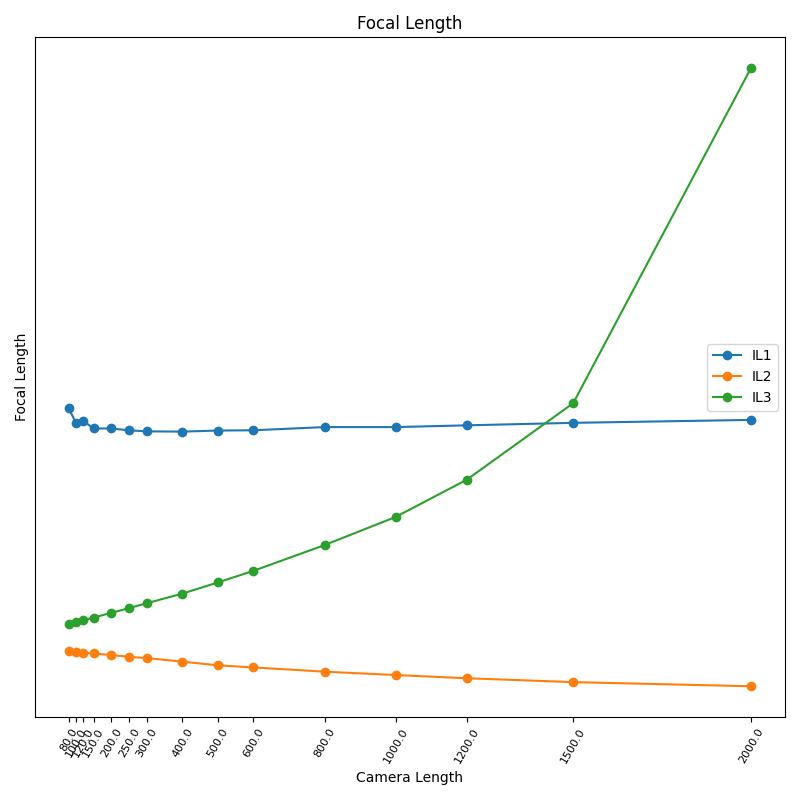

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_title('Focal Length')
ax.set_xlabel('Camera Length')
ax.set_ylabel('Focal Length')

lens_f_dict = {}
cameralengths_sorted = sorted([float(k) for k in data.keys()])
ax.set_xticks(cameralengths_sorted)
ax.set_xticklabels(cameralengths_sorted)
ax.tick_params(axis='x', rotation=60, labelsize=8)
ax.set_yticks([])
for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    focal_length = 1/(decimal**2)
    ax.plot(cameralength, focal_length, label=lens, marker='o', linestyle='-')
    lens_f_dict[lens] = focal_length
ax.legend(loc='center right')
plt.tight_layout()
plt.show()


In [6]:
from scipy.optimize import curve_fit

lenses = (
 "IL1", 
 "IL2", 
 "IL3",
)

def model_IL3(x, A, B, C, D, E):
    return (A * jnp.exp(B * x) + C * x ** 2 + D * x + E)

def model_IL1_IL2(x, a, b, c, d):
    return (a / x**2 + b * x **3 + c * x + d)

for lens in lenses:
    cameralength = np.array(results[lens])[:, 0]
    decimal = np.array(results[lens])[:, 1]
    focal_length = 1/(decimal**2)

    if lens == "IL3":
        popt, pcov = curve_fit(model_IL3, cameralength, focal_length, p0=(1.0, 0.001, 0.01, 0.0001, 0.0001))
        IL3_params = popt
        fitted_focal_length = model_IL3(cameralength, *popt)
    else:
        popt, pcov = curve_fit(model_IL1_IL2, cameralength, focal_length)
        fitted_focal_length = model_IL1_IL2(cameralength, *popt)
        if lens == "IL2":
            IL2_params = popt
        else:
            IL1_params = popt

    ax.plot(cameralength, fitted_focal_length, label=f'{lens} Fit')
    ax.legend()


Plot the rays at each plane. 

Matrix([[6.93889390390723e-16, -0.000529000000000000], [1890.35916824197, 0.00166027783906042]])
Matrix([[-2.09406466404502e-14, 0.0159645070615080], [-62.6389525305857, -0.0634616645604971]])
Matrix([[2.63214769423798e-12, -2.00401783292116], [0.498997555604904, -6.18569036471162]])
Intermediate Lens 1 Magnification: -0.23
Intermidiate Lens 2 & 3 Magnification: -30.178652290185234
Projector Lens Magnification: -125.52957790679363
Camera Length cm: MP * M3&2 * M1 * f_obj -200.4017832921124


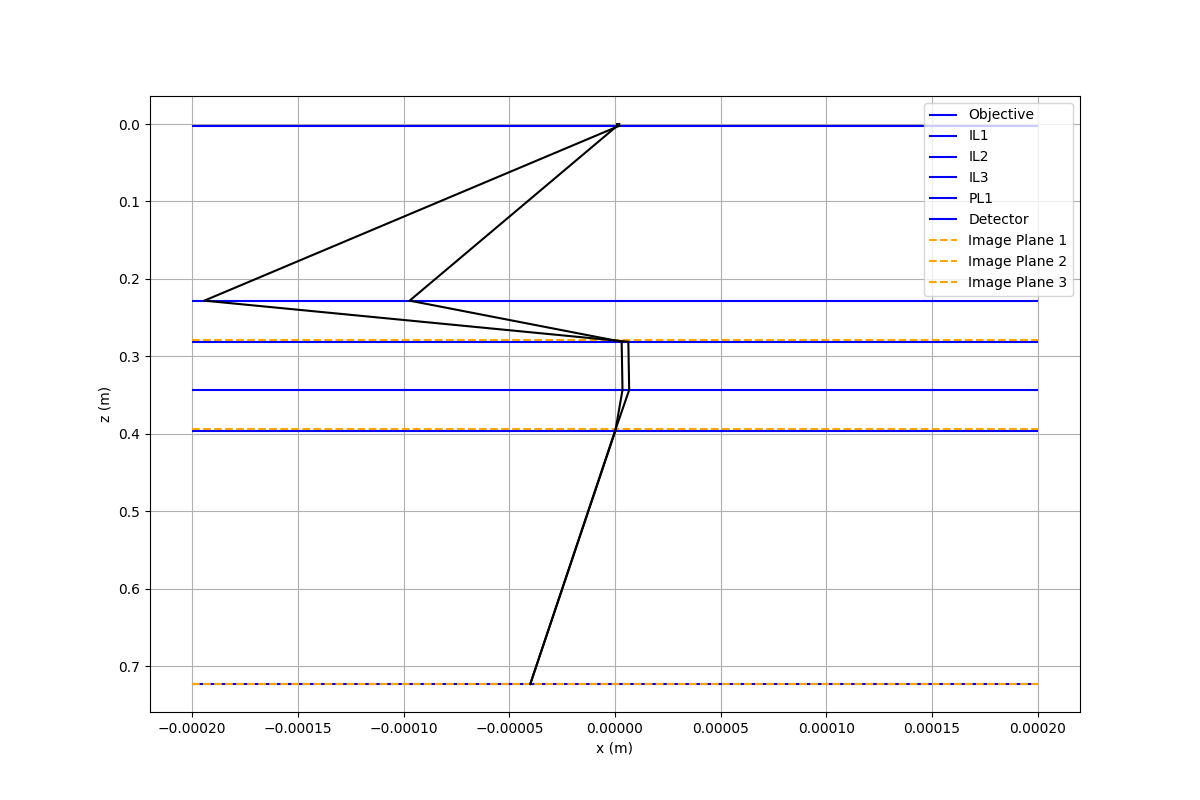

In [7]:
def apply_matrix(rays, matrix):
    return np.array([matrix @ r for r in rays])

z0 = 0.0
z_obj = 0.00233
f_obj = 0.0023

# Input rays
x_in = np.array([[0.000001, 0.00002], [0.000002, 0.00002]])

# Optical elements
il1_zobj = -(z_il1_m - (z_obj + f_obj))
M_il1 = -0.23
il1_f = (il1_zobj * M_il1) / (1 - M_il1)
il1_zimg = calculate_image_plane(il1_zobj, il1_f)

il2_zobj = -(z_il2_m - (z_il1_m + il1_zimg))
il2_f = np.abs(il2_zobj)

il3_f = 0.05046

pl1_zobj = -(z_pl1_m - (z_il3_m + il3_f))
pl1_f = calculate_focal_length(-pl1_zobj, z_det_m - z_pl1_m)
pl1_zimg = calculate_image_plane(pl1_zobj, pl1_f)
M_pl1 = pl1_zimg / pl1_zobj

# Matrices
d1 = propagation_matrix(z_obj, xp=np)
f1 = thin_lens_matrix(f_obj)
d2 = propagation_matrix(z_il1_m - z_obj, xp=np)
f2 = thin_lens_matrix(il1_f, xp=np)
d3 = propagation_matrix(il1_zimg, xp=np)
d4 = propagation_matrix(il2_f, xp=np)
f3 = thin_lens_matrix(il2_f, xp=np)
d5 = propagation_matrix(z_il3_m - z_il2_m, xp=np)
f4 = thin_lens_matrix(il3_f, xp=np)
d6 = propagation_matrix(il3_f, xp=np)
d7 = propagation_matrix(np.abs(pl1_zobj), xp=np)
f5 = thin_lens_matrix(pl1_f, xp=np)
d8 = propagation_matrix(z_det_m - z_pl1_m, xp=np)

# Composite matrices
IL1_image_plane_matrix = d3 @ f2 @ d2 @ f1 @ d1
IL3_focal_plane_matrix = d6 @ f4 @ d5 @ f3 @ d4 @ IL1_image_plane_matrix
M_il2_il3 = (d6 @ f4 @ d5 @ f3 @ d4)[0, 0]
det_image_plane_matrix = d8 @ f5 @ d7 @ IL3_focal_plane_matrix

print(IL1_image_plane_matrix)
print(IL3_focal_plane_matrix)
print(det_image_plane_matrix)
print("Intermediate Lens 1 Magnification:", M_il1)
print("Intermidiate Lens 2 & 3 Magnification:", M_il2_il3)
print("Projector Lens Magnification:", M_pl1)
print("Camera Length cm: MP * M3&2 * M1 * f_obj", (M_pl1 * M_il2_il3 * M_il1 * f_obj)*100)

# Ray tracing through each stage
x_coords = [x_in]
z_coords = [z0]

# Store the matrices in a list
matrices = [d1, f1, d2, f2, d3, d4, f3, d5, f4, d6, d7, f5, d8]

rays = x_in

# Apply each matrix in sequence and store the results
for matrix in matrices:
    rays = apply_matrix(rays, matrix)
    x_coords.append(rays)
    z_coords.append(z_coords[-1] + matrix[0, 1])

# Final rays after all matrices
x_out = rays

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
components = ['Objective', 'IL1', 'IL2', 'IL3', 'PL1', 'Detector']
z_positions = [z_obj, z_il1_m, z_il2_m, z_il3_m, z_pl1_m, z_det_m]

for z, component in zip(z_positions, components):
    ax.hlines(z, xmin=-0.0002, xmax=0.0002, colors='b', linestyles='-', label=component)

# Image planes
image_planes = [z_il1_m + il1_zimg, z_il3_m + il3_f, z_pl1_m + pl1_zimg]
for idx, img_z in enumerate(image_planes):
    ax.hlines(img_z, xmin=-0.0002, xmax=0.0002,
              colors='orange', linestyles='--', label=f'Image Plane {idx+1}')

# Plot the rays
for i in range(len(x_in)):
    ax.plot([x_coords[j][i][0] for j in range(len(x_coords))], z_coords, 'k-')

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.invert_yaxis()
ax.legend()
ax.grid(True)
plt.show()


In [8]:
import optax

camera_lengths = jnp.array(sorted([float(key) for key in data.keys()])) # convert from centimetres to metres. 
camera_lengths = camera_lengths / 100

optimizer = optax.adam(1e-3)

run_function = jax.jit(run_to_end)
run_function_grad = jax.jit(jax.jacobian(run_to_end))

def create_model(i11_f, il2_f, il3_f, pl1_f):
    return [
        comp.Lens(z=z_obj, focal_length=f_obj),
        comp.Lens(z=z_il1_m, focal_length=i11_f),
        comp.Lens(z=z_il2_m, focal_length=il2_f),
        comp.Lens(z=z_il3_m, focal_length=il3_f),
        comp.Lens(z=z_pl1_m, focal_length=pl1_f),
        comp.Detector(z=z_det_m, pixel_size=0.01, shape=(100, 100))
    ]

def create_ray(num_models):
    return PointBeam(z=0.0, n_rays=num_models, semi_angle=0.0, tilt_yx=(0, 1e-5), voltage=jnp.ones(num_models))

# Batch parameters
start_index = 4
num_models = 7
camera_length_batch = jnp.array(camera_lengths[start_index:start_index+num_models])

# a, b, c, d = jnp.ones(4) * 1e-3

# # camera_length_batch
# IL1_f_batch = a * model_IL1_IL2(camera_length_batch, *IL1_params)
# IL2_f_batch = b * model_IL1_IL2(camera_length_batch, *IL2_params)
# IL3_f_batch = c * model_IL3(camera_length_batch, *IL3_params)
# pl1_f_batch = d * jnp.ones(num_models)

# # Vectorize model creation
# models = jax.vmap(create_model)(IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch)

# # Create a single ray for each model
# ray_batch = create_ray(num_models)

# # Vectorize the run functions
# ray_out = jax.vmap(run_function, in_axes=(0, 0))(ray_batch, models)
# ray_grad_out = jax.vmap(run_function_grad, in_axes=(0, 0))(ray_batch, models)

# ABCD = ray_grad_out.matrix.squeeze()
# print(ABCD.shape)
# A = ABCD[0, 0]
# B = ABCD[0, 2]
# C = ABCD[2, 0]
# D = ABCD[2, 2]

# print(A, B, C, D)

In [9]:
# @jax.jit
def forward_pass(p):
    a, b, c, d = p

    IL1_f_batch = a * model_IL1_IL2(camera_length_batch, *IL1_params)
    IL2_f_batch = b * model_IL1_IL2(camera_length_batch, *IL2_params)
    IL3_f_batch = c * model_IL3(camera_length_batch, *IL3_params)
    pl1_f_batch = d * jnp.ones(num_models)

    models = jax.vmap(create_model)(IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch)

    ray_grad_out = jax.vmap(run_function_grad, in_axes=(0, 0))(rays, models)
    ABCD = ray_grad_out.matrix.squeeze()

    return ABCD, IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch

# @jax.jit
def loss_fn(p):
    ABCD, IL1_f_batch, IL2_f_batch, IL3_f_batch, pl1_f_batch = forward_pass(p)
    
    A = ABCD[:, 0, 0]
    B = ABCD[:, 0, 2]
    C = ABCD[:, 2, 0]

    per_model_loss = (
        (A) ** 2
        + (B - camera_length_batch) ** 2
        + (C + 1.0 / camera_length_batch) ** 2
    )

    loss = jnp.mean(per_model_loss) * 1.0  # Adjust scaling factor as needed

    penalty_il1_f = jnp.mean(jnp.square(jnp.maximum(0.0, 0.01 - p[0]))) + jnp.mean(jnp.square(jnp.maximum(0.0, p[0] - 0.05)))
    
    pl1_object_planes = calculate_object_plane(-pl1_f_batch, z_det_m)
    pl1_object_planes_dist_to_IL3 = jnp.abs(pl1_object_planes - z_il3_m)
    
    penalty_focal_IL3 = jnp.mean(jnp.square(IL3_f_batch - pl1_object_planes_dist_to_IL3))
    
    penalty_pl1_f = jnp.sum(jnp.square(jnp.maximum(0.0, pl1_f_batch - 0.01)))
    
    scale_penalties = 1e6
    
    loss += scale_penalties * (penalty_il1_f + penalty_focal_IL3 + penalty_pl1_f)

    negative_penalty = jnp.sum(jnp.square(jnp.minimum(0.0, p)))
    scale_negative_penalty = 1e8
    loss += scale_negative_penalty * negative_penalty

    return loss


  0%|          | 0/1000 [00:00<?, ?it/s]

[69.69021198 44.77511311 31.24098892 17.78377108 11.55501014  8.17149286
  4.80721595]
[3.72532011 2.41064975 1.69650099 0.98639483 0.65770104 0.47913764
 0.30155869]
[0.10309966 0.10314876 0.10319788 0.10329616 0.10339451 0.10349292
 0.10368992]
0.09624387567934783
[68.35579888 43.91776893 30.64279323 17.44325128 11.3337573   8.01502688
  4.71516842]
[3.61562496 2.33966616 1.6465461  0.95734961 0.63833448 0.46502903
 0.29267904]
[0.1059297  0.10598015 0.10603061 0.10613159 0.10623264 0.10633375
 0.10653616]
0.09724340233132236
[67.02145298 43.06046793 30.04462765 17.10274863 11.11251561  7.85856879
  4.62312552]
[3.50589728 2.26866152 1.59657641 0.92829578 0.61896218 0.45091624
 0.28379676]
[0.10875064 0.10880243 0.10885424 0.10895791 0.10906165 0.10916545
 0.10937326]
0.09824206808765325
[65.68713334 42.2031838  29.44647386 16.76225268 10.89127827  7.70211377
  4.53108444]
[3.39611626 2.19762238 1.54658242 0.89922783 0.59958047 0.43679659
 0.27491017]
[0.11155918 0.11161231 0.1116654

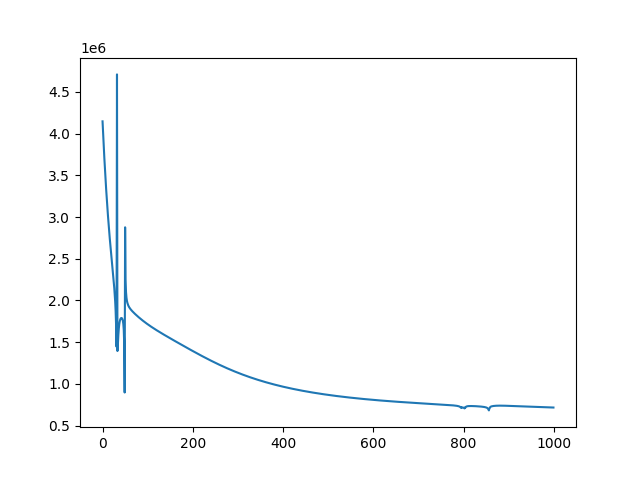

In [10]:
key = jax.random.PRNGKey(0)
a, b, c, d = jax.random.uniform(key, shape=(4,), minval=0, maxval=0.1)

init_guess = jnp.array([a, b, c, d])
opt_state = optimizer.init(init_guess)
params = init_guess

rays = create_ray(num_models)

loss_val_list =[]
n_steps = 1000

for step in tqdm.trange(n_steps):
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_val_list.append(loss_val)

    print(params[0] * model_IL1_IL2(camera_length_batch, *IL1_params))
    print(params[1] * model_IL1_IL2(camera_length_batch, *IL2_params))
    print(params[2] * model_IL3(camera_length_batch, *IL3_params))
    print(params[3])

plt.figure()
plt.plot(loss_val_list)

print(params)



In [11]:
# il2_f = params[1] + params[2] * jnp.abs(camera_length)
# il3_f = params[3] - params[4] * jnp.abs(camera_length)

# model = [
#     comp.Lens(z=0.00233, focal_length=f_obj),
#     comp.Lens(z=z_il1_m, focal_length=params[0]),
#     comp.Lens(z=z_il2_m, focal_length=il2_f),
#     comp.Lens(z=z_il3_m, focal_length=il3_f),
#     comp.Lens(z=z_pl1_m, focal_length=pl1_f),
#     comp.Detector(z=z_det_m, pixel_size=0.01, shape=(100, 100)),
# ]

# ro = run_to_end(ray, model)
# print(ro)
# dro_dri = jax.jacobian(run_to_end, argnums=0)(ray, model)
# ABCD = dro_dri.matrix.squeeze()
# A = ABCD[0, 0]
# B = ABCD[0, 2]
# C = ABCD[2, 0]
# D = ABCD[2, 2]
# print(A, B, C)
# print(camera_length)